# RMS clustering using K-Means

* How are distributed the values ?
* Scaling/Centering of the values

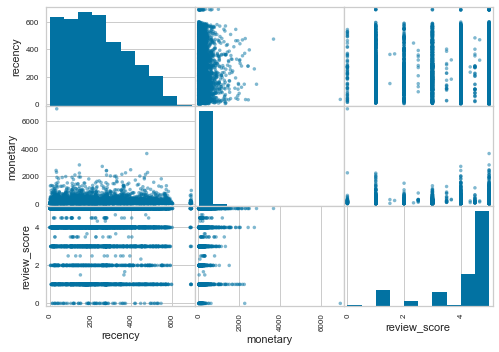

In [107]:
import pandas as pd
from sklearn.model_selection import train_test_split

rms = pd.read_csv("./../../../output/rms.csv")

rms = rms[["recency", "monetary", "review_score"]]
y = rms["review_score"]
X_train, X_test, y_train, y_test = train_test_split(
    rms, y, test_size=0.12, random_state=42, stratify=y
)
rms = X_test

pd.plotting.scatter_matrix(rms);

In [108]:
rms.skew(numeric_only=True)

recency         0.453709
monetary        7.560310
review_score   -1.483425
dtype: float64

In [109]:
rms.describe()

,recency,monetary,review_score
count,11173.000000,11173.000000,11173.000000
mean,236.445449,163.287954,4.126316
std,151.927129,211.112242,1.319294
min,1.000000,14.130000,0.000000
25%,113.000000,64.090000,4.000000
50%,219.000000,108.220000,5.000000
75%,344.000000,182.710000,5.000000
max,695.000000,6922.210000,5.000000


Sadly, and as we may expect the distribution of the satisfaction variables  really skewed.

We will probably have poor performance from KMeans

In [110]:
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler, PowerTransformer

pipeline = make_pipeline(StandardScaler(), PowerTransformer())

scaled_customers = pipeline.fit_transform(rms)

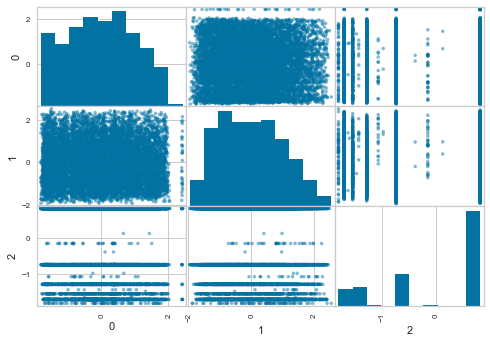

In [111]:
pd.plotting.scatter_matrix(pd.DataFrame(scaled_customers));

In [112]:
scaled_customers

array([[ 1.79208786, -0.8617057 , -1.28007748],
       [-0.23575395, -1.19001793, -1.28007748],
       [-1.63058429, -0.22604882,  0.81309664],
       ...,
       [ 0.94952281, -0.09293809, -0.73791819],
       [-1.21549723,  0.24202356,  0.81309664],
       [-1.41154875,  1.08574943,  0.81309664]])

### Evaluation of the right number of clusters

How can we evaluate the right number of clusters ? We can use the following methods:

* The elbow method ;
* The silhouette analysis ;
* The Davies Bouldin score ;

Read [This article](https://becominghuman.ai/3-minute-read-to-how-to-find-optimal-number-of-clusters-using-k-means-algorithm-eaa6bdce92cc) for additional information.

#### Elbow Method

Elbow method gives us an idea on what a good _k_ number of clusters would be based on the sum of squared distance (SSE) between data points and their assigned clusters' centroids.

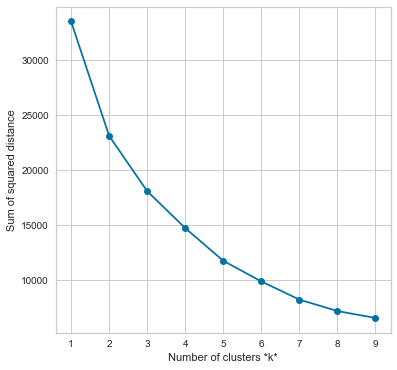

In [113]:
import matplotlib.pyplot as plt
from sklearn.cluster import KMeans

# Run the Kmeans algorithm and get the index of data points clusters
sse = []
list_k = list(range(1, 10))

for k in list_k:
    km = KMeans(n_clusters=k, random_state=42)
    km.fit(scaled_customers)
    sse.append(km.inertia_)

# Plot sse against k
plt.figure(figsize=(6, 6))
plt.plot(list_k, sse, "-o")
plt.xlabel(r"Number of clusters *k*")
plt.ylabel("Sum of squared distance");

The graph above shows that `k = 6` is a good choice. Sometimes it’s still hard to figure out a good number of clusters to use because the curve is monotonically decreasing and may not show any elbow or has an obvious point where the curve starts flattening out.

#### Silhouette Analysis

The **silhouette** analysis is used to evaluate the degree of separation between the clusters.
What we want is all points of a cluster as close as possible and the distance between the clusters as big as possible !

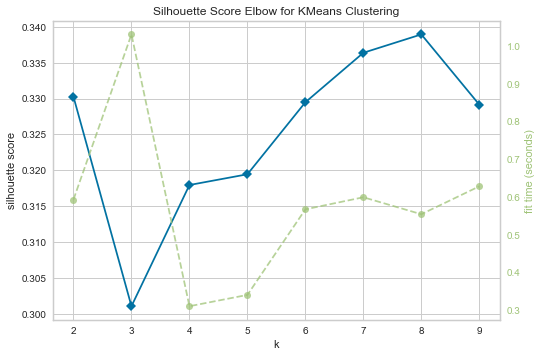

In [114]:
from yellowbrick.cluster import KElbowVisualizer

kmeans = KMeans()
visualizer = KElbowVisualizer(
    kmeans, k=(2, 10), metric="silhouette", locate_elbow=False
)
# Fit the data and visualize
visualizer.fit(scaled_customers)
visualizer.show();

From the silhouette score, it confirms that `k = 7` is an optimal choice.

#### Davies-Bouldin Index

It is defined as a ratio between the cluster scatter and the cluster’s separation.
Basically a ratio of within-cluster distance and between cluster distances. Aim is to find optimal value in which clusters are less dispersed internally and are farther apart from each other (i.e. distance between two clusters is high).
Hence, a lower value of Davies-Bouldin index will mean that the clustering is better.


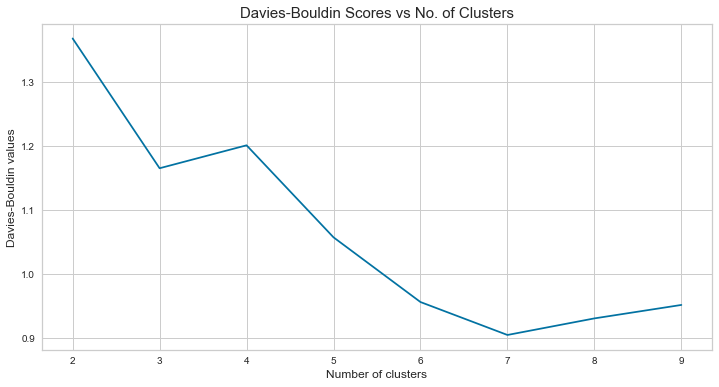

In [115]:
from sklearn.metrics import davies_bouldin_score

db_scores = {}

for k in range(2, 10):
    kmeans = KMeans(n_clusters=k, random_state=42)
    kmeans.fit(scaled_customers)
    labels = kmeans.labels_
    db_scores[k] = davies_bouldin_score(scaled_customers, labels)

# Plotting Davies-Bouldin Scores
plt.figure(figsize=(12, 6))
plt.plot(list(db_scores.keys()), list(db_scores.values()))
plt.xlabel("Number of clusters", fontsize=12)
plt.ylabel("Davies-Bouldin values", fontsize=12)
plt.title("Davies-Bouldin Scores vs No. of Clusters", fontsize=15)
plt.show()

The analysis of the Davies-Bouldin Scores versus the number of clusters also indicates **in favor of 7 clusters** !

Let's plot our clusters and display the silhouette plot for theses :

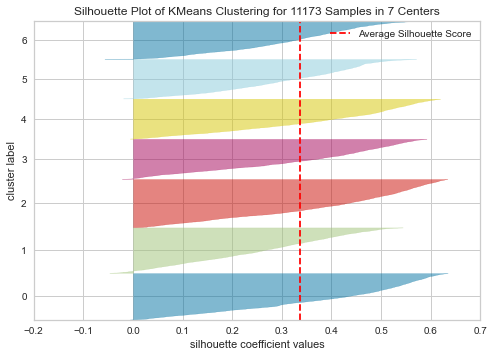

In [116]:
from yellowbrick.cluster import SilhouetteVisualizer

kmeans = KMeans(7, random_state=42)

s_visualizer = SilhouetteVisualizer(kmeans, colors="yellowbrick")
s_visualizer.fit(scaled_customers)
s_visualizer.show();

#### Projection on two dimensions

Using t-SNE reduction method, let's project our clustering using 2 dimensions.

In [117]:
from sklearn.manifold import TSNE

kmeans = KMeans(n_clusters=7, random_state=42)
kmeans.fit(scaled_customers)
clusters = kmeans.labels_

rms["cluster"] = clusters
rms.cluster = rms.cluster.astype("category")
tsne = TSNE(n_components=2, learning_rate="auto", init="random")
projected_customers = tsne.fit_transform(scaled_customers)

In [118]:
import plotly.express as px

fig = px.scatter(
    projected_customers,
    x=0,
    y=1,
    color=rms.cluster,
    labels={"color": "cluster"},
    opacity=0.8,
)
fig.show()

In [119]:
print("END")

END
